# Window function and amplitude correction

In [1]:
from radiocalibrationtoolkit import *
from scipy.signal import butter, lfilter
from scipy.signal import blackmanharris, boxcar, hann

[INFO] LFmap: Import successful.


In [2]:
# some global plot settings
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12

plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2

plt.rcParams["xtick.major.size"] = 5
plt.rcParams["ytick.major.size"] = 5

plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

## Examine effects on a single trace

In [3]:
N = 2048   # samples
fs_Hz = 250e6 # sampling frequency
signal_freq_Hz = 55.5e6 # signal
win = blackmanharris(N) # window function type

In [4]:
tx = np.arange(N) / fs_Hz
def make_simple_time_trace(signal_amplitude=0.7, signal_frequency=55.5e+6, noise_amplitude=1, N=2048, apply_filter=True):
    time_trace = signal_amplitude * np.sin(2*np.pi*signal_frequency*tx) + noise_amplitude * np.random.normal(size=N)
    b, a = butter(5, [30e6, 80e6], fs=250e6, btype='band')
    if apply_filter:
        time_trace = lfilter(b, a, time_trace)
    return np.round(time_trace * N) / N

Text(0, 0.5, 'amplitude [ADC]')

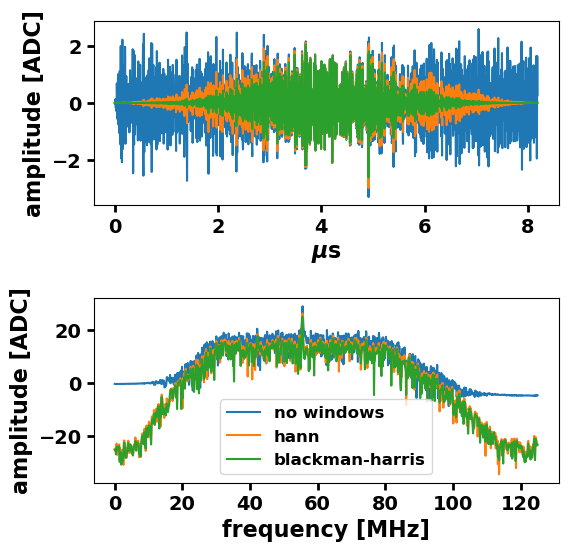

In [5]:
tt = make_simple_time_trace(signal_amplitude=1)
fx = np.fft.rfftfreq(N, 1/fs_Hz)*1e-6

fig, ax = plt.subplots(2,1, figsize=(6,6))
labels = ['no windows', 'hann', 'blackman-harris']
for i, w in enumerate([1, hann(N), blackmanharris(N)]):
    ax[0].plot(tx*1e+6, tt*w)
    ax[1].plot(fx, 10*np.log10(np.abs(np.fft.rfft(tt*w))), label=labels[i])

fig.subplots_adjust(hspace=0.5)
ax[1].legend()

ax[0].set_xlabel("$\mu$s")
ax[1].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("amplitude [ADC]")
ax[1].set_ylabel("amplitude [ADC]")


In [6]:
# generate time trace
time_trace = make_simple_time_trace()

# calculate two sided spectrum
spectrum = np.abs(fft(time_trace))
# calculate one sided spectrum (not corrected for the one side)
rspectrum = np.abs(np.fft.rfft(time_trace))

# calculate one sided spectrum (corrected for the one side)
r2spectrum = correct_energy_of_one_sided_spectrum(rspectrum)

# calculate amplitude window function correction
Aw = N/np.sum(win) /np.sqrt(2)

# calculate two sided spectrum using a window function (not corrected for the one side)
spectrum_w = np.abs(fft(time_trace*win))
# calculate one sided spectrum using a window function (not corrected for the one side)
rspectrum_w = np.abs(np.fft.rfft(time_trace*win))

# calculate one sided spectrum (corrected for the one side)
r2spectrum = correct_energy_of_one_sided_spectrum(rspectrum)
r2spectrum_w = correct_energy_of_one_sided_spectrum(rspectrum_w)

# define X-axis values
fx = np.fft.rfftfreq(N, 1/fs_Hz)/1e+6

In [7]:
# calculate energy from time trace, one and two sided spectrum with and without window
# when the window is used, the amplitudes are corrected
print(
    f"Energy calculated from:\n"
    f"time trace = {get_energy_from_time_trace(time_trace):.2f},\n"
    f"two sided spectrum = {get_energy_from_two_sided_spectrum(spectrum):.2f},\n"
    f"one sided spectrum = {get_energy_from_one_sided_spectrum(rspectrum):.2f},\n"
    f"windowed two sided spectrum = {get_energy_from_two_sided_spectrum(spectrum_w):.2f},\n"
    f"one sided spectrum corrected for being the one sided spectrum = {get_energy_from_one_sided_spectrum_corrected4one_side(r2spectrum):.2f},\n"
    f"windowed two sided spectrum corrected by window function loss = {get_energy_from_two_sided_spectrum(spectrum_w * Aw):.2f},\n"
    f"windowed one sided spectrum corrected by window function loss = {get_energy_from_one_sided_spectrum(rspectrum_w * Aw):.2f},\n"
    f"one sided spectrum corrected for being the one sided spectrum and for window function loss = {get_energy_from_one_sided_spectrum_corrected4one_side(r2spectrum_w*Aw):.2f},\n"
)

Energy calculated from:
time trace = 1291.81,
two sided spectrum = 1291.81,
one sided spectrum = 1291.81,
windowed two sided spectrum = 304.30,
one sided spectrum corrected for being the one sided spectrum = 1291.81,
windowed two sided spectrum corrected by window function loss = 1183.36,
windowed one sided spectrum corrected by window function loss = 1183.36,
one sided spectrum corrected for being the one sided spectrum and for window function loss = 1183.36,



### Trace with a broad band pulse

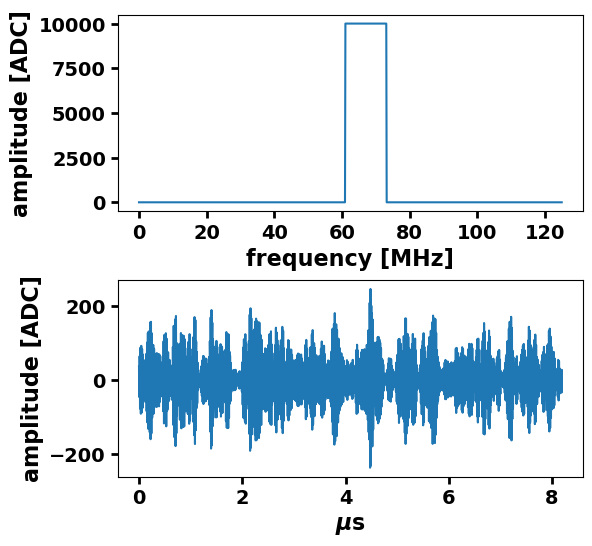

In [8]:
# create a broad band noise trace
bb_spec=np.zeros(1025)
bb_spec[500:600] = 10000


bb_tt = np.real(ifft(one_sided_2_complex_two_sided(bb_spec)))

fig, ax = plt.subplots(2,1, figsize=(6,6))

ax[0].set_xlabel("frequency [MHz]")
ax[0].set_ylabel("amplitude [ADC]")
ax[1].set_ylabel("amplitude [ADC]")
ax[1].set_xlabel("$\mu$s")

ax[0].plot(fx, bb_spec)
ax[1].plot(tx*1e+6, bb_tt)

fig.subplots_adjust(hspace=0.35)

In [9]:
# add broad band pulse to the time trace
time_trace_e = time_trace.copy()
time_trace_e[np.arange(1024, 1024+40)] = bb_tt[:40]

rspectrum_e = np.abs(np.fft.rfft(time_trace_e))
rspectrum_w_e = np.abs(np.fft.rfft(time_trace_e*win))


In [10]:
def show_plots(time_trace, show_window_func=True):
    rspectrum = np.abs(np.fft.rfft(time_trace))
    rspectrum_w = np.abs(np.fft.rfft(time_trace * win))
    Aw = N / np.sum(win) / np.sqrt(2)

    e_tt = get_energy_from_time_trace(time_trace)
    e_spec = get_energy_from_one_sided_spectrum(rspectrum)
    e_spec_w = get_energy_from_one_sided_spectrum(rspectrum_w * Aw)

    fig, ax = plt.subplots(2, 1, figsize=(6, 6))

    mu = 1e6
    ax[0].plot(
        tx * mu, time_trace, label="no window: E={:.1f} a.u.".format(e_tt), alpha=0.7
    )
    ax[0].plot(tx * mu, time_trace * win, label="windowed", alpha=0.7)
    
    if show_window_func:
        ax[0].plot(tx * mu, win * 100, label="window func. x100", alpha=1)

    ax[1].plot(
        fx , rspectrum, label="no window:         E={:.1f} a.u.".format(e_spec), alpha=0.7
    )

    ax[1].plot(
        fx ,
        rspectrum_w * Aw,
        label="windowed & A$_w$: E={:.1f} a.u.".format(e_spec_w),
        alpha=0.7,
    )

    display(
        get_energy_from_time_trace(time_trace),
        get_energy_from_one_sided_spectrum(rspectrum),
        get_energy_from_one_sided_spectrum(rspectrum_w * Aw),
    )

    ax[0].set_xlabel("$\mu$s")
    ax[1].set_xlabel("frequency [MHz]")
    ax[0].set_ylabel("amplitude [ADC]")
    ax[1].set_ylabel("amplitude [ADC]")

    ax[0].legend()
    ax[1].legend()
    
    fig.subplots_adjust(hspace=0.3)

1291.8132836818695

1291.8132836818695

1183.3550584650752

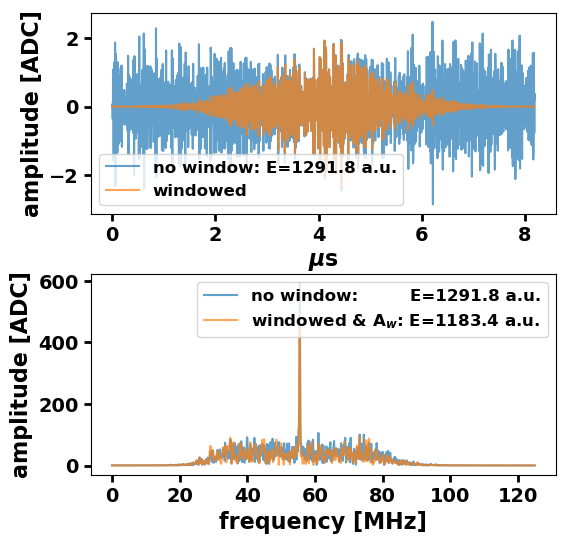

In [11]:
# trace without the broad band pulse
show_plots(time_trace, show_window_func=False)

124731.45336155407

124731.4533615541

478527.9191753803

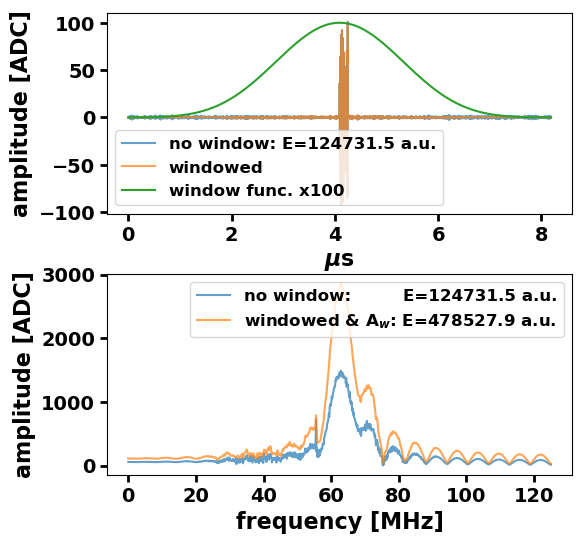

In [12]:
# trace with the broad band pulse
time_trace_e = time_trace.copy()
time_trace_e[np.arange(1024, 1024+40)] = bb_tt[:40]
show_plots(time_trace_e)

124731.45336155407

124731.4533615541

21958.974009980957

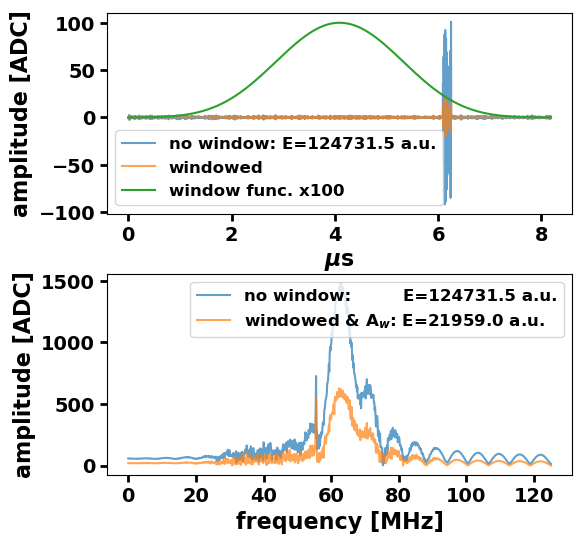

In [13]:
# rolled trace to shift the broad band pulse
show_plots(np.roll(time_trace_e, 500))

The learning here is that a amplitudes of a trace with broad band pulse cannot be safely corrected
after the window function because the window function is symmetric and the broad band pulse appearing 
in random parts of the trace will be each time differently supressed by the window function.

Note that the energy of the trace is after the rolling of the trace still the same when no window is used.

## Distributions of the energy ratios of not windowed spectra and windowed spectra with amplitude correction

In [14]:
def get_averaged_spectra_and_diffs(arr):
    diffs = np.array([])
    n, N = arr.shape
    avr_rspectrum = 0
    avr_rspectrum_w = 0
    win = blackmanharris(N)
    Aw = N / np.sum(win) / np.sqrt(2)
    for i in range(n):
        time_trace = arr[i, :]
        rspectrum = np.abs(np.fft.rfft(time_trace))
        rspectrum_w = np.abs(np.fft.rfft(time_trace * win))
        diffs = np.append(
            diffs,
            get_energy_from_time_trace(time_trace)
            / get_energy_from_one_sided_spectrum(rspectrum_w * Aw),
        )
        avr_rspectrum += rspectrum
        avr_rspectrum_w += rspectrum_w

    avr_rspectrum /= n
    avr_rspectrum_w /= n
    return avr_rspectrum, avr_rspectrum_w, diffs


def show_results(
    avr_rspectrum,
    avr_rspectrum_w,
    diffs,
    histo_edge=2,
    N=2048,
    bins=None,
    xax_min=None,
    xax_max=None,
    xlim= [None, None]
):
    fig, ax = plt.subplots()
    fx = np.fft.rfftfreq(N, 1 / fs_Hz) / 1e6

    if bins == None:
        bins = linspace_with_middle_value(
            np.mean(diffs), histo_edge * np.std(diffs), 20
        )
    ax.hist(diffs, bins=bins)
    # Calculate mean and standard deviation
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)

    print(mean_diff)
    print(std_diff)

    # Add text box with mean and standard deviation
    text_box = f"$\mu$: {mean_diff:.2f}\n$\sigma$: {std_diff:.2f}"
    ax.text(
        0.95,
        0.95,
        text_box,
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
    )

    ax.set_xlim(xax_min, xax_max)
    ax.set_xlabel(
        r"$\frac{\mathrm{energy: \ spectrum \ with \ no\ window}}{\mathrm{energy:spectrum \ with\ window,\ amplitudes\ corrected}}$"
    )
    ax.set_ylabel("entries")

    fig, ax = plt.subplots()

    ax.plot(fx, voltageAmp2dB(avr_rspectrum), alpha=0.7, label="no window")
    ax.plot(fx, voltageAmp2dB(avr_rspectrum_w), alpha=0.7, label="with window")
    ax.plot(
        fx,
        voltageAmp2dB(avr_rspectrum_w * Aw),
        alpha=0.7,
        label="with window " + "\n" + "and corrected",
    )
    
    
    # ax.axes.axvspan(30,80, color='b', alpha=0.1)
    ax.set_xlim(*xlim)
    autoscale_y(ax)     
    
    ax.set_xlabel("frequency [MHz]")
    ax.set_ylabel("dB")
    ax.legend()

### Simple traces

In [15]:
# create a set of 1000 time traces
n = 1000
avr_rspectrum = 0
avr_rspectrum_w = 0
time_traces = make_simple_time_trace()
for i in range(n-1):
    time_traces = np.vstack((time_traces, make_simple_time_trace()))

In [16]:
# calculate energy ratios of unwindowed spectra and windowed with amplitude correction
# and average spectra
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(time_traces)
diffs1 = diffs
label4final_histo = ['simple traces']

0.9970330527436879
0.06105278433322218


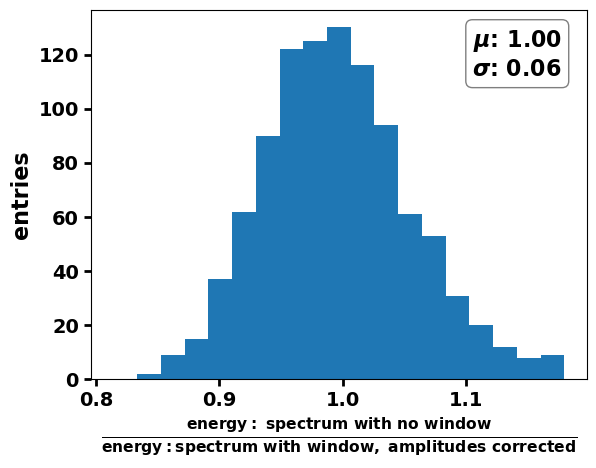

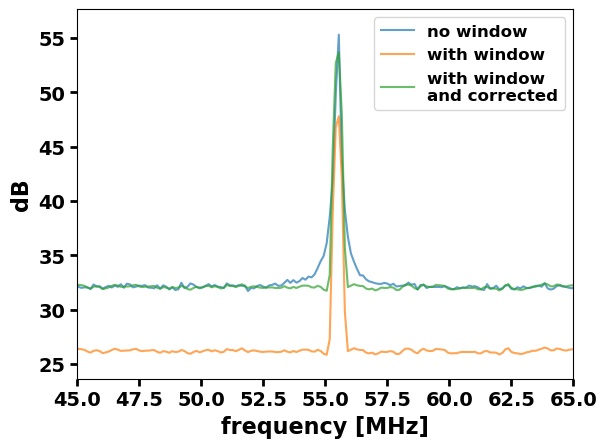

In [17]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3, xlim=[45, 65])

In [18]:
# create a set of 1000 time traces with bb pulses
n = 1000
avr_rspectrum = 0
avr_rspectrum_w = 0
time_traces = make_simple_time_trace()
for i in range(n-1):
    time_trace = make_simple_time_trace()
    start_bb_index = np.random.randint(0, 2048-40)
    time_trace[np.arange(start_bb_index, start_bb_index+40)] = bb_tt[:40]
    time_traces = np.vstack((time_traces, time_trace))

In [19]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(time_traces)

30.245086584253347
38.008926013838796


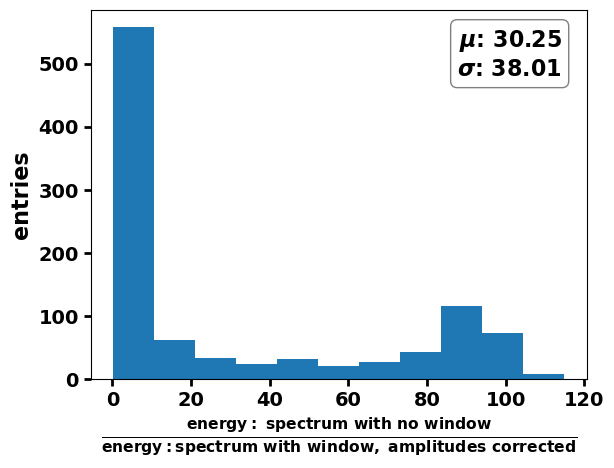

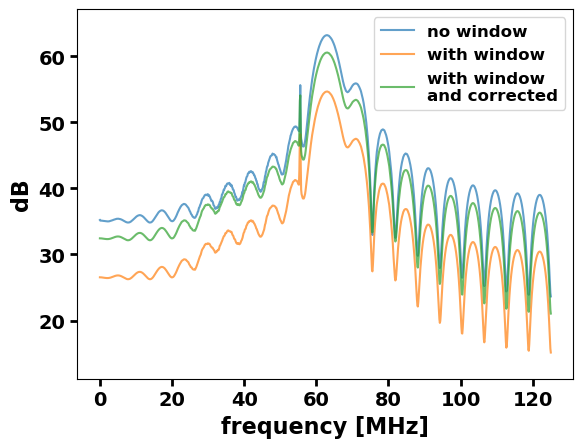

In [20]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3, bins='auto')
# ,xax_min=-10, xax_max=80)

### Mock traces

In [21]:
# read HW response
hw_file_path = "./antenna_setup_files/HardwareProfileList_realistic.xml"
hw_dict = read_hw_file(hw_file_path, interp_args={"fill_value": "extrapolate"})

hw_reponse_1 = hw_dict["RResponse"]["LNA"]
hw_reponse_2 = hw_dict["RResponse"]["digitizer"]
hw_reponse_3 = hw_dict["RResponse"]["cable_fromLNA2digitizer"]
hw_reponse_4 = hw_dict["RResponse"]["impedance_matching_EW"]


# merge all hw responses to one function
def hw_response_func(x):
    return dB2PowerAmp(
        hw_reponse_1(x) + hw_reponse_2(x) + hw_reponse_3(x) + hw_reponse_4(x)
    )


# impedance function
impedance_func = hw_dict["IImpedance"][
    "antenna_EW"
]

# read sidereal voltage square spectral density
sidereal_voltage2_density_DF = pd.read_csv(
    "./voltage2_density/voltage2_density_Salla_EW_GSM16.csv",
    index_col=0,
)
sidereal_voltage2_density_DF.columns = sidereal_voltage2_density_DF.columns.astype(
    float
)

<?xml version="1.0" encoding="iso-8859-1"?>
<Element HardwareProfileList at 0x7fc028d0fd00>


In [22]:
mock_trace_generator = Mock_trace_generator(
    sidereal_voltage2_density_DF=sidereal_voltage2_density_DF,
    hw_response_func=hw_response_func,
    impedance_func=impedance_func,
    voltage2ADC=2048,
    time_trace_size=2048,
    sampling_frequency_MHz=250,
)
freq_MHz_bins = mock_trace_generator.get_frequency_bins()

In [23]:
piko = 1e-12
additional_noise = 5e-4*piko
debug_spectra_dict = mock_trace_generator.generate_mock_trace(
    1,
    lst=15,
    temp_celsius=30,
    nbi={"67.2": 1},
    nbi_err=0.2,
    return_debug_dict=True,
    additional_noise=additional_noise,
)[0]

  0%|                                                                                                                                  | 0/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 210.08it/s]

In [24]:
number_of_traces = 1000
mock_traces_DF = mock_trace_generator.generate_mock_trace(
    number_of_traces,
    temp_celsius=[-10,30],
    additional_noise=additional_noise,
    nbi={"67.25": 1},
    nbi_err=0.3,
)

  0%|                                                                                                                               | 0/1000 [00:00<?, ?it/s]

  0%|▍                                                                                                                      | 4/1000 [00:00<00:28, 34.51it/s]

  1%|▉                                                                                                                      | 8/1000 [00:00<00:29, 34.10it/s]

  1%|█▍                                                                                                                    | 12/1000 [00:00<00:29, 33.72it/s]

  2%|█▉                                                                                                                    | 16/1000 [00:00<00:29, 33.82it/s]

  2%|██▎                                                                                                                   | 20/1000 [00:00<00:29, 33.16it/s]

  2%|██▊                                                                                                                   | 24/1000 [00:00<00:29, 33.37it/s]

  3%|███▎                                                                                                                  | 28/1000 [00:00<00:29, 33.45it/s]

  3%|███▊                                                                                                                  | 32/1000 [00:00<00:28, 33.40it/s]

  4%|████▏                                                                                                                 | 36/1000 [00:01<00:28, 33.35it/s]

  4%|████▋                                                                                                                 | 40/1000 [00:01<00:28, 33.51it/s]

  4%|█████▏                                                                                                                | 44/1000 [00:01<00:28, 33.59it/s]

  5%|█████▋                                                                                                                | 48/1000 [00:01<00:28, 33.68it/s]

  5%|██████▏                                                                                                               | 52/1000 [00:01<00:28, 33.73it/s]

  6%|██████▌                                                                                                               | 56/1000 [00:01<00:28, 33.13it/s]

  6%|███████                                                                                                               | 60/1000 [00:01<00:28, 33.34it/s]

  6%|███████▌                                                                                                              | 64/1000 [00:01<00:28, 33.22it/s]

  7%|████████                                                                                                              | 68/1000 [00:02<00:32, 28.89it/s]

  7%|████████▍                                                                                                             | 72/1000 [00:02<00:30, 29.97it/s]

  8%|████████▉                                                                                                             | 76/1000 [00:02<00:29, 30.91it/s]

  8%|█████████▍                                                                                                            | 80/1000 [00:02<00:29, 31.58it/s]

  8%|█████████▉                                                                                                            | 84/1000 [00:02<00:28, 32.05it/s]

  9%|██████████▍                                                                                                           | 88/1000 [00:02<00:28, 31.90it/s]

  9%|██████████▊                                                                                                           | 92/1000 [00:02<00:28, 32.08it/s]

 10%|███████████▎                                                                                                          | 96/1000 [00:02<00:28, 32.21it/s]

 10%|███████████▋                                                                                                         | 100/1000 [00:03<00:27, 32.66it/s]

 10%|████████████▏                                                                                                        | 104/1000 [00:03<00:27, 32.64it/s]

 11%|████████████▋                                                                                                        | 108/1000 [00:03<00:27, 32.31it/s]

 11%|█████████████                                                                                                        | 112/1000 [00:03<00:27, 32.10it/s]

 12%|█████████████▌                                                                                                       | 116/1000 [00:03<00:27, 32.42it/s]

 12%|██████████████                                                                                                       | 120/1000 [00:03<00:27, 32.28it/s]

 12%|██████████████▌                                                                                                      | 124/1000 [00:03<00:27, 32.44it/s]

 13%|██████████████▉                                                                                                      | 128/1000 [00:03<00:26, 32.63it/s]

 13%|███████████████▍                                                                                                     | 132/1000 [00:04<00:26, 32.68it/s]

 14%|███████████████▉                                                                                                     | 136/1000 [00:04<00:26, 32.81it/s]

 14%|████████████████▍                                                                                                    | 140/1000 [00:04<00:26, 32.74it/s]

 14%|████████████████▊                                                                                                    | 144/1000 [00:04<00:25, 33.18it/s]

 15%|█████████████████▎                                                                                                   | 148/1000 [00:04<00:25, 32.93it/s]

 15%|█████████████████▊                                                                                                   | 152/1000 [00:04<00:26, 32.06it/s]

 16%|██████████████████▎                                                                                                  | 156/1000 [00:04<00:26, 32.12it/s]

 16%|██████████████████▋                                                                                                  | 160/1000 [00:04<00:26, 32.16it/s]

 16%|███████████████████▏                                                                                                 | 164/1000 [00:05<00:25, 32.24it/s]

 17%|███████████████████▋                                                                                                 | 168/1000 [00:05<00:25, 32.43it/s]

 17%|████████████████████                                                                                                 | 172/1000 [00:05<00:25, 32.67it/s]

 18%|████████████████████▌                                                                                                | 176/1000 [00:05<00:25, 32.80it/s]

 18%|█████████████████████                                                                                                | 180/1000 [00:05<00:25, 32.32it/s]

 18%|█████████████████████▌                                                                                               | 184/1000 [00:05<00:25, 32.35it/s]

 19%|█████████████████████▉                                                                                               | 188/1000 [00:05<00:24, 32.49it/s]

 19%|██████████████████████▍                                                                                              | 192/1000 [00:05<00:24, 32.73it/s]

 20%|██████████████████████▉                                                                                              | 196/1000 [00:06<00:24, 32.60it/s]

 20%|███████████████████████▍                                                                                             | 200/1000 [00:06<00:24, 32.52it/s]

 20%|███████████████████████▊                                                                                             | 204/1000 [00:06<00:24, 32.64it/s]

 21%|████████████████████████▎                                                                                            | 208/1000 [00:06<00:24, 32.57it/s]

 21%|████████████████████████▊                                                                                            | 212/1000 [00:06<00:24, 31.90it/s]

 22%|█████████████████████████▎                                                                                           | 216/1000 [00:06<00:24, 31.57it/s]

 22%|█████████████████████████▋                                                                                           | 220/1000 [00:06<00:24, 31.79it/s]

 22%|██████████████████████████▏                                                                                          | 224/1000 [00:06<00:24, 31.79it/s]

 23%|██████████████████████████▋                                                                                          | 228/1000 [00:07<00:24, 31.91it/s]

 23%|███████████████████████████▏                                                                                         | 232/1000 [00:07<00:23, 32.10it/s]

 24%|███████████████████████████▌                                                                                         | 236/1000 [00:07<00:23, 32.69it/s]

 24%|████████████████████████████                                                                                         | 240/1000 [00:07<00:22, 33.19it/s]

 24%|████████████████████████████▌                                                                                        | 244/1000 [00:07<00:22, 33.46it/s]

 25%|█████████████████████████████                                                                                        | 248/1000 [00:07<00:22, 33.55it/s]

 25%|█████████████████████████████▍                                                                                       | 252/1000 [00:07<00:22, 33.18it/s]

 26%|█████████████████████████████▉                                                                                       | 256/1000 [00:07<00:22, 33.43it/s]

 26%|██████████████████████████████▍                                                                                      | 260/1000 [00:07<00:22, 33.59it/s]

 26%|██████████████████████████████▉                                                                                      | 264/1000 [00:08<00:21, 33.71it/s]

 27%|███████████████████████████████▎                                                                                     | 268/1000 [00:08<00:21, 33.85it/s]

 27%|███████████████████████████████▊                                                                                     | 272/1000 [00:08<00:21, 33.84it/s]

 28%|████████████████████████████████▎                                                                                    | 276/1000 [00:08<00:21, 33.83it/s]

 28%|████████████████████████████████▊                                                                                    | 280/1000 [00:08<00:21, 33.82it/s]

 28%|█████████████████████████████████▏                                                                                   | 284/1000 [00:08<00:21, 33.44it/s]

 29%|█████████████████████████████████▋                                                                                   | 288/1000 [00:08<00:21, 33.54it/s]

 29%|██████████████████████████████████▏                                                                                  | 292/1000 [00:08<00:21, 33.63it/s]

 30%|██████████████████████████████████▋                                                                                  | 296/1000 [00:09<00:20, 33.74it/s]

 30%|███████████████████████████████████                                                                                  | 300/1000 [00:09<00:20, 33.84it/s]

 30%|███████████████████████████████████▌                                                                                 | 304/1000 [00:09<00:20, 33.86it/s]

 31%|████████████████████████████████████                                                                                 | 308/1000 [00:09<00:20, 33.89it/s]

 31%|████████████████████████████████████▌                                                                                | 312/1000 [00:09<00:20, 33.94it/s]

 32%|████████████████████████████████████▉                                                                                | 316/1000 [00:09<00:20, 33.67it/s]

 32%|█████████████████████████████████████▍                                                                               | 320/1000 [00:09<00:20, 33.55it/s]

 32%|█████████████████████████████████████▉                                                                               | 324/1000 [00:09<00:20, 33.62it/s]

 33%|██████████████████████████████████████▍                                                                              | 328/1000 [00:09<00:19, 33.70it/s]

 33%|██████████████████████████████████████▊                                                                              | 332/1000 [00:10<00:19, 33.74it/s]

 34%|███████████████████████████████████████▎                                                                             | 336/1000 [00:10<00:19, 33.78it/s]

 34%|███████████████████████████████████████▊                                                                             | 340/1000 [00:10<00:19, 33.84it/s]

 34%|████████████████████████████████████████▏                                                                            | 344/1000 [00:10<00:19, 33.83it/s]

 35%|████████████████████████████████████████▋                                                                            | 348/1000 [00:10<00:19, 33.82it/s]

 35%|█████████████████████████████████████████▏                                                                           | 352/1000 [00:10<00:19, 33.33it/s]

 36%|█████████████████████████████████████████▋                                                                           | 356/1000 [00:10<00:19, 33.47it/s]

 36%|██████████████████████████████████████████                                                                           | 360/1000 [00:10<00:19, 33.58it/s]

 36%|██████████████████████████████████████████▌                                                                          | 364/1000 [00:11<00:18, 33.64it/s]

 37%|███████████████████████████████████████████                                                                          | 368/1000 [00:11<00:18, 33.72it/s]

 37%|███████████████████████████████████████████▌                                                                         | 372/1000 [00:11<00:18, 33.80it/s]

 38%|███████████████████████████████████████████▉                                                                         | 376/1000 [00:11<00:18, 33.78it/s]

 38%|████████████████████████████████████████████▍                                                                        | 380/1000 [00:11<00:18, 33.78it/s]

 38%|████████████████████████████████████████████▉                                                                        | 384/1000 [00:11<00:18, 33.71it/s]

 39%|█████████████████████████████████████████████▍                                                                       | 388/1000 [00:11<00:18, 33.70it/s]

 39%|█████████████████████████████████████████████▊                                                                       | 392/1000 [00:11<00:18, 33.72it/s]

 40%|██████████████████████████████████████████████▎                                                                      | 396/1000 [00:12<00:17, 33.73it/s]

 40%|██████████████████████████████████████████████▊                                                                      | 400/1000 [00:12<00:17, 33.70it/s]

 40%|███████████████████████████████████████████████▎                                                                     | 404/1000 [00:12<00:17, 33.74it/s]

 41%|███████████████████████████████████████████████▋                                                                     | 408/1000 [00:12<00:17, 33.76it/s]

 41%|████████████████████████████████████████████████▏                                                                    | 412/1000 [00:12<00:17, 33.74it/s]

 42%|████████████████████████████████████████████████▋                                                                    | 416/1000 [00:12<00:17, 33.77it/s]

 42%|█████████████████████████████████████████████████▏                                                                   | 420/1000 [00:12<00:17, 33.38it/s]

 42%|█████████████████████████████████████████████████▌                                                                   | 424/1000 [00:12<00:17, 33.42it/s]

 43%|██████████████████████████████████████████████████                                                                   | 428/1000 [00:12<00:17, 33.55it/s]

 43%|██████████████████████████████████████████████████▌                                                                  | 432/1000 [00:13<00:16, 33.67it/s]

 44%|███████████████████████████████████████████████████                                                                  | 436/1000 [00:13<00:16, 33.73it/s]

 44%|███████████████████████████████████████████████████▍                                                                 | 440/1000 [00:13<00:16, 33.79it/s]

 44%|███████████████████████████████████████████████████▉                                                                 | 444/1000 [00:13<00:16, 33.77it/s]

 45%|████████████████████████████████████████████████████▍                                                                | 448/1000 [00:13<00:16, 33.54it/s]

 45%|████████████████████████████████████████████████████▉                                                                | 452/1000 [00:13<00:16, 33.16it/s]

 46%|█████████████████████████████████████████████████████▎                                                               | 456/1000 [00:13<00:16, 33.34it/s]

 46%|█████████████████████████████████████████████████████▊                                                               | 460/1000 [00:13<00:16, 33.46it/s]

 46%|██████████████████████████████████████████████████████▎                                                              | 464/1000 [00:14<00:15, 33.50it/s]

 47%|██████████████████████████████████████████████████████▊                                                              | 468/1000 [00:14<00:15, 33.49it/s]

 47%|███████████████████████████████████████████████████████▏                                                             | 472/1000 [00:14<00:15, 33.57it/s]

 48%|███████████████████████████████████████████████████████▋                                                             | 476/1000 [00:14<00:17, 29.65it/s]

 48%|████████████████████████████████████████████████████████▏                                                            | 480/1000 [00:14<00:16, 30.95it/s]

 48%|████████████████████████████████████████████████████████▋                                                            | 484/1000 [00:14<00:16, 31.51it/s]

 49%|█████████████████████████████████████████████████████████                                                            | 488/1000 [00:14<00:16, 31.91it/s]

 49%|█████████████████████████████████████████████████████████▌                                                           | 492/1000 [00:14<00:15, 31.93it/s]

 50%|██████████████████████████████████████████████████████████                                                           | 496/1000 [00:15<00:15, 31.83it/s]

 50%|██████████████████████████████████████████████████████████▌                                                          | 500/1000 [00:15<00:15, 31.81it/s]

 50%|██████████████████████████████████████████████████████████▉                                                          | 504/1000 [00:15<00:15, 31.77it/s]

 51%|███████████████████████████████████████████████████████████▍                                                         | 508/1000 [00:15<00:15, 31.75it/s]

 51%|███████████████████████████████████████████████████████████▉                                                         | 512/1000 [00:15<00:15, 31.62it/s]

 52%|████████████████████████████████████████████████████████████▎                                                        | 516/1000 [00:15<00:15, 31.01it/s]

 52%|████████████████████████████████████████████████████████████▊                                                        | 520/1000 [00:15<00:15, 31.66it/s]

 52%|█████████████████████████████████████████████████████████████▎                                                       | 524/1000 [00:15<00:15, 31.64it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                       | 528/1000 [00:16<00:14, 31.48it/s]

 53%|██████████████████████████████████████████████████████████████▏                                                      | 532/1000 [00:16<00:14, 31.56it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                      | 536/1000 [00:16<00:14, 31.63it/s]

 54%|███████████████████████████████████████████████████████████████▏                                                     | 540/1000 [00:16<00:14, 31.65it/s]

 54%|███████████████████████████████████████████████████████████████▋                                                     | 544/1000 [00:16<00:14, 31.56it/s]

 55%|████████████████████████████████████████████████████████████████                                                     | 548/1000 [00:16<00:14, 30.41it/s]

 55%|████████████████████████████████████████████████████████████████▌                                                    | 552/1000 [00:16<00:14, 30.60it/s]

 56%|█████████████████████████████████████████████████████████████████                                                    | 556/1000 [00:16<00:14, 30.58it/s]

 56%|█████████████████████████████████████████████████████████████████▌                                                   | 560/1000 [00:17<00:14, 30.62it/s]

 56%|█████████████████████████████████████████████████████████████████▉                                                   | 564/1000 [00:17<00:14, 30.65it/s]

 57%|██████████████████████████████████████████████████████████████████▍                                                  | 568/1000 [00:17<00:14, 30.60it/s]

 57%|██████████████████████████████████████████████████████████████████▉                                                  | 572/1000 [00:17<00:13, 30.60it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                 | 576/1000 [00:17<00:14, 30.22it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 580/1000 [00:17<00:13, 30.18it/s]

 58%|████████████████████████████████████████████████████████████████████▎                                                | 584/1000 [00:17<00:13, 30.27it/s]

 59%|████████████████████████████████████████████████████████████████████▊                                                | 588/1000 [00:18<00:13, 30.37it/s]

 59%|█████████████████████████████████████████████████████████████████████▎                                               | 592/1000 [00:18<00:13, 30.46it/s]

 60%|█████████████████████████████████████████████████████████████████████▋                                               | 596/1000 [00:18<00:13, 30.47it/s]

 60%|██████████████████████████████████████████████████████████████████████▏                                              | 600/1000 [00:18<00:13, 30.51it/s]

 60%|██████████████████████████████████████████████████████████████████████▋                                              | 604/1000 [00:18<00:12, 30.55it/s]

 61%|███████████████████████████████████████████████████████████████████████▏                                             | 608/1000 [00:18<00:12, 30.52it/s]

 61%|███████████████████████████████████████████████████████████████████████▌                                             | 612/1000 [00:18<00:12, 30.44it/s]

 62%|████████████████████████████████████████████████████████████████████████                                             | 616/1000 [00:18<00:12, 30.48it/s]

 62%|████████████████████████████████████████████████████████████████████████▌                                            | 620/1000 [00:19<00:12, 30.43it/s]

 62%|█████████████████████████████████████████████████████████████████████████                                            | 624/1000 [00:19<00:12, 30.42it/s]

 63%|█████████████████████████████████████████████████████████████████████████▍                                           | 628/1000 [00:19<00:12, 30.44it/s]

 63%|█████████████████████████████████████████████████████████████████████████▉                                           | 632/1000 [00:19<00:12, 30.49it/s]

 64%|██████████████████████████████████████████████████████████████████████████▍                                          | 636/1000 [00:19<00:11, 30.49it/s]

 64%|██████████████████████████████████████████████████████████████████████████▉                                          | 640/1000 [00:19<00:11, 30.43it/s]

 64%|███████████████████████████████████████████████████████████████████████████▎                                         | 644/1000 [00:19<00:11, 30.47it/s]

 65%|███████████████████████████████████████████████████████████████████████████▊                                         | 648/1000 [00:20<00:11, 30.49it/s]

 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 652/1000 [00:20<00:11, 30.52it/s]

 66%|████████████████████████████████████████████████████████████████████████████▊                                        | 656/1000 [00:20<00:11, 30.51it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 660/1000 [00:20<00:11, 30.54it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▋                                       | 664/1000 [00:20<00:10, 30.56it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▏                                      | 668/1000 [00:20<00:10, 30.37it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▌                                      | 672/1000 [00:20<00:11, 29.27it/s]

 68%|███████████████████████████████████████████████████████████████████████████████                                      | 676/1000 [00:20<00:10, 29.66it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 680/1000 [00:21<00:11, 26.73it/s]

 68%|████████████████████████████████████████████████████████████████████████████████                                     | 684/1000 [00:21<00:11, 27.84it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 688/1000 [00:21<00:10, 28.63it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▉                                    | 692/1000 [00:21<00:10, 29.18it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 696/1000 [00:21<00:10, 29.57it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▊                                   | 699/1000 [00:21<00:10, 29.16it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▎                                  | 703/1000 [00:21<00:10, 29.53it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 707/1000 [00:22<00:09, 29.81it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▏                                 | 711/1000 [00:22<00:09, 30.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▋                                 | 715/1000 [00:22<00:09, 30.25it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████                                 | 719/1000 [00:22<00:09, 30.36it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▌                                | 723/1000 [00:22<00:09, 30.45it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████                                | 727/1000 [00:22<00:08, 30.51it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▌                               | 731/1000 [00:22<00:08, 30.17it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▉                               | 735/1000 [00:22<00:08, 30.25it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▍                              | 739/1000 [00:23<00:08, 30.36it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▉                              | 743/1000 [00:23<00:08, 30.41it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▍                             | 747/1000 [00:23<00:08, 30.43it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 751/1000 [00:23<00:08, 30.47it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                            | 755/1000 [00:23<00:08, 30.24it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▊                            | 759/1000 [00:23<00:08, 29.95it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▎                           | 763/1000 [00:23<00:07, 30.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                           | 767/1000 [00:23<00:07, 30.23it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 771/1000 [00:24<00:07, 30.28it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▋                          | 775/1000 [00:24<00:07, 30.35it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▏                         | 779/1000 [00:24<00:07, 30.40it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 783/1000 [00:24<00:07, 30.42it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                         | 787/1000 [00:24<00:06, 30.47it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▌                        | 791/1000 [00:24<00:06, 30.06it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                        | 795/1000 [00:24<00:06, 29.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▍                       | 799/1000 [00:25<00:06, 30.07it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 803/1000 [00:25<00:06, 30.21it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                      | 807/1000 [00:25<00:06, 30.30it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▉                      | 811/1000 [00:25<00:06, 30.17it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 815/1000 [00:25<00:06, 30.18it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▊                     | 819/1000 [00:25<00:06, 26.33it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 823/1000 [00:25<00:06, 27.41it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 827/1000 [00:26<00:06, 28.20it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 831/1000 [00:26<00:05, 28.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 835/1000 [00:26<00:05, 29.32it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 839/1000 [00:26<00:05, 29.65it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 842/1000 [00:26<00:05, 29.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 846/1000 [00:26<00:05, 29.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 849/1000 [00:26<00:05, 29.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 852/1000 [00:26<00:04, 29.63it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 856/1000 [00:27<00:04, 29.97it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 860/1000 [00:27<00:04, 30.11it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████                | 864/1000 [00:27<00:04, 30.26it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 868/1000 [00:27<00:04, 30.33it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 872/1000 [00:27<00:04, 30.35it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 876/1000 [00:27<00:04, 29.99it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 879/1000 [00:27<00:04, 29.93it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 882/1000 [00:27<00:03, 29.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 886/1000 [00:27<00:03, 29.99it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 890/1000 [00:28<00:03, 30.13it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 894/1000 [00:28<00:03, 30.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 898/1000 [00:28<00:03, 30.33it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 902/1000 [00:28<00:03, 30.42it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████           | 906/1000 [00:28<00:03, 30.41it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 910/1000 [00:28<00:03, 29.92it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 913/1000 [00:28<00:02, 29.52it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 916/1000 [00:29<00:02, 29.45it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 919/1000 [00:29<00:02, 29.35it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 922/1000 [00:29<00:02, 29.31it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 925/1000 [00:29<00:02, 29.29it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 928/1000 [00:29<00:02, 29.07it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 931/1000 [00:29<00:02, 28.99it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 934/1000 [00:29<00:02, 29.08it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 937/1000 [00:29<00:02, 29.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 940/1000 [00:29<00:02, 28.70it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 943/1000 [00:29<00:01, 28.85it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 946/1000 [00:30<00:01, 29.00it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 949/1000 [00:30<00:01, 28.98it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 952/1000 [00:30<00:01, 29.02it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 955/1000 [00:30<00:01, 29.05it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 958/1000 [00:30<00:01, 29.02it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 961/1000 [00:30<00:01, 29.07it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 964/1000 [00:30<00:01, 29.12it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 967/1000 [00:30<00:01, 28.91it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 970/1000 [00:30<00:01, 29.04it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 974/1000 [00:30<00:00, 29.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 978/1000 [00:31<00:00, 29.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 982/1000 [00:31<00:00, 29.97it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 986/1000 [00:31<00:00, 30.07it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 990/1000 [00:31<00:00, 30.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 994/1000 [00:31<00:00, 30.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [00:31<00:00, 30.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.39it/s]

In [25]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(mock_traces_DF.iloc[:,2:].values)
diffs2 = diffs
label4final_histo.append('mock traces')

0.998437804031123
0.049548480193377376


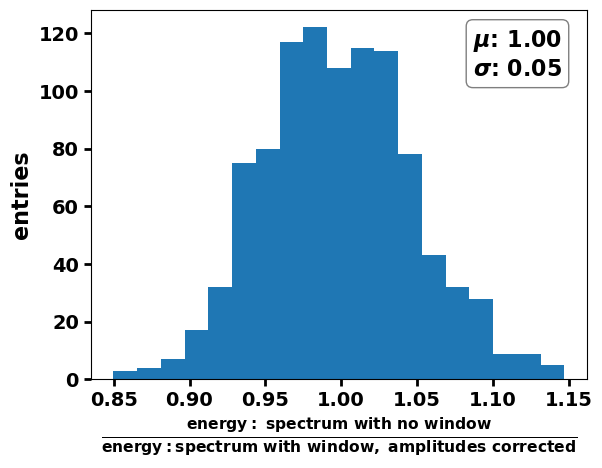

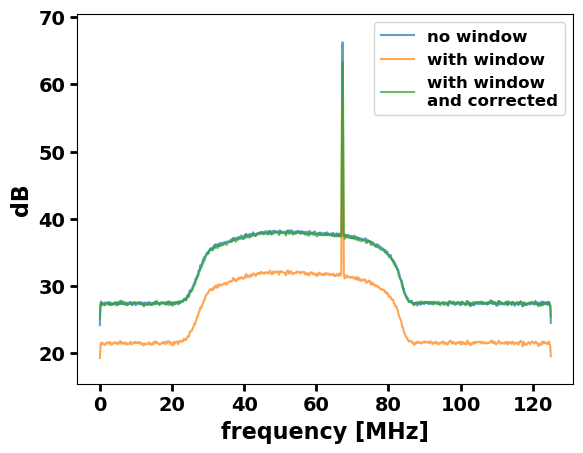

In [26]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3)

In [27]:
mock_traces_with_BB_DF = mock_traces_DF.copy(deep=True)
for i in range(mock_traces_with_BB_DF.index.size):
    start_bb_index = np.random.randint(0, 2048-40)
    time_trace = mock_traces_with_BB_DF.iloc[i,2:].values
    time_trace[np.arange(start_bb_index, start_bb_index+40)] = bb_tt[:40]
    mock_traces_with_BB_DF.iloc[i,2:] = time_trace

In [28]:
avr_rspectrum, avr_rspectrum_w, diffs = get_averaged_spectra_and_diffs(mock_traces_with_BB_DF.iloc[:,2:].values)
diffs3 = diffs
label4final_histo.append('mock traces with BB pulse')

7.8614674336582855
8.409582534559249


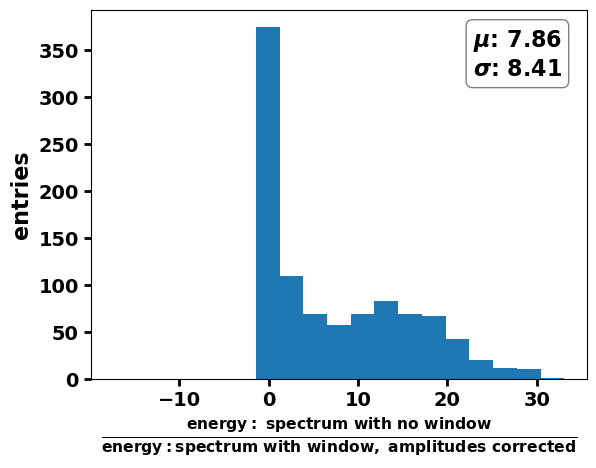

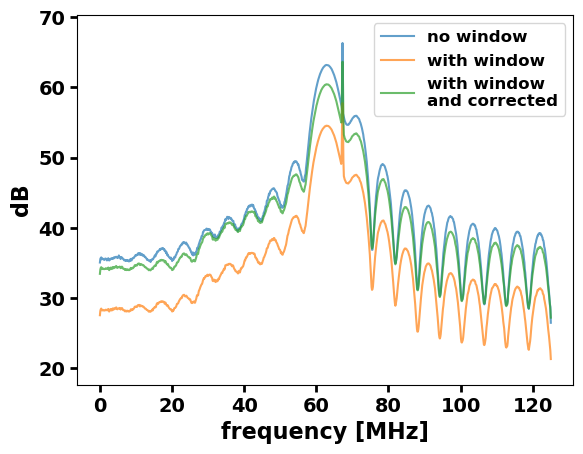

In [29]:
show_results(avr_rspectrum, avr_rspectrum_w, diffs, histo_edge=3)

### Summary

simple traces
Mean and STD:-0.0030, 0.0611
Truncated Mean and STD: -0.0030, 0.0611
******
mock traces
Mean and STD:-0.0016, 0.0495
Truncated Mean and STD: -0.0016, 0.0495
******
mock traces with BB pulse
Mean and STD:6.8615, 8.4096
Truncated Mean and STD: 6.8615, 8.4096
******


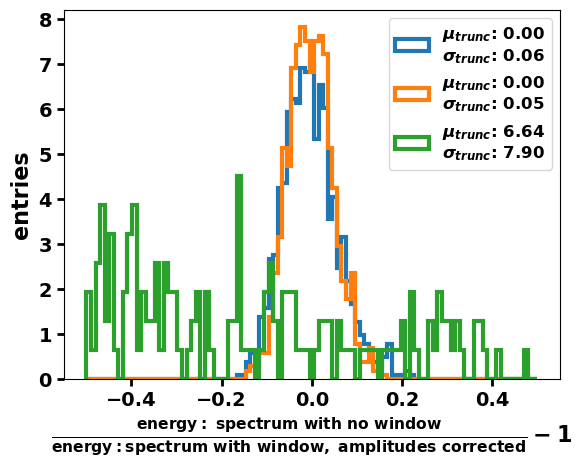

In [30]:
fig, ax = plt.subplots()
fx = np.fft.rfftfreq(N, 1 / fs_Hz) / 1e6

diffs_list = np.asarray([diffs1, diffs2, diffs3], dtype="object") - 1
# diffs_list = [diffs1, diffs2]

bins = np.histogram_bin_edges(np.concatenate(diffs_list), bins=20)


# if bins == None:
bins = linspace_with_middle_value(
    np.mean(np.concatenate(diffs_list)), 2 * np.std(np.concatenate(diffs_list)), 20
)

bins = np.linspace(0.5, 1.5, 100) - 1

for i, diffs in enumerate(diffs_list):
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    mean_diff_trun, std_diff_trun = calculate_truncated_stats(diffs, 1, 99)
    label = (
        text_box
    ) = f"$\mu_{{trunc}}$: {round(mean_diff_trun,2)+0:.2f}\n$\sigma_{{trunc}}$: {round(std_diff_trun,2)+0:.2f}"
    ax.hist(diffs, bins=bins, alpha=1, density=True, histtype="step", lw=3, label=label)
    # Calculate mean and standard deviation
    print(label4final_histo[i])
    print('Mean and STD:{:.4f}, {:.4f}'.format(mean_diff, std_diff))
    print('Truncated Mean and STD: {:.4f}, {:.4f}'.format(mean_diff, std_diff))
    print("******")

# ax.set_xlim(xax_min, xax_max)
ax.set_xlabel(
    r"$\frac{\mathrm{energy: \ spectrum \ with \ no\ window}}{\mathrm{energy:spectrum \ with\ window,\ amplitudes\ corrected}} -1$"
)
ax.set_ylabel("entries")
ax.legend()

In [31]:
print('The colors corespond to')
print(label4final_histo)
print(', respectively.')

The colors corespond to
['simple traces', 'mock traces', 'mock traces with BB pulse']
, respectively.


CONCLUSION: The broad band pulse in the trace spoils the energy recovery.